# Word Level Federated Text Generation with Stack Overflow with Randomly Initialized or Pretrained Word Embeddings
- Joel Stremmel
- 02-20-20
- Runs on GCP and local Ubuntu 16.04

**About:**

This notebook loads the Stack Overflow data available through `tff.simulation.datasets` and trains an LSTM model with Federared Averaging by following the Federated Learning for Text Generation [example notebook](https://github.com/tensorflow/federated/blob/master/docs/tutorials/federated_learning_for_text_generation.ipynb).  The embedding layer is initialized with one of the following options by setting the `EMBEDDING_LAYER` parameter:
- [GloVe](https://nlp.stanford.edu/projects/glove/) ([license here](https://www.opendatacommons.org/licenses/pddl/1.0/))
- [FastText](https://fasttext.cc/docs/en/english-vectors.html) ([license here](https://creativecommons.org/licenses/by-sa/3.0/))
- [GPT-2](https://openai.com/blog/better-language-models/) ([license here](https://github.com/huggingface/transformers/blob/master/LICENSE))
- [Randomly initialized embeddings](https://www.tensorflow.org/api_docs/python/tf/random_uniform_initializer)  

After downloading the GloVe or FastText embeddings, place the embedding files at the top level of the repository in directories called `word_embedding/glove` and `word_embedding/fasttext` respectively.  GPT-2 embeddings are downloaded by running the notebook which makes a call to `src/embeddings.py` to download the embeddings from [huggingface](https://github.com/huggingface/transformers).  

**Code from Tensorflow Federated:**

- This notebook prepares the Stack Overflow dataset for word level language modeling using this [module](https://github.com/tensorflow/federated/blob/master/tensorflow_federated/python/research/baselines/stackoverflow/dataset.py
).
- The metrics for model training come from this [module](https://github.com/tensorflow/federated/blob/master/tensorflow_federated/python/research/baselines/stackoverflow/metrics.py). 


**Data and Model References:**
- [TFF Stack Overflow `load_data`](https://www.tensorflow.org/federated/api_docs/python/tff/simulation/datasets/stackoverflow/load_data)
- [TFF text generation tutorial](https://github.com/tensorflow/federated/blob/master/docs/tutorials/federated_learning_for_text_generation.ipynb)
- [Google TFF team research baselines for Stack Overflow](https://github.com/tensorflow/federated/tree/master/tensorflow_federated/python/research/baselines/stackoverflow)
- [Tensorflow text generation tutorial](https://www.tensorflow.org/tutorials/text/text_generation)

**Environment Setup References:**
- [Installing Tensorflow for GPU](https://www.tensorflow.org/install/gpu)
- [Install CUDA 10.0 and cuDNN v7.4.2 on Ubuntu 16.04](https://gist.github.com/matheustguimaraes/43e0b65aa534db4df2918f835b9b361d)
- [Tensorflow build configs](https://www.tensorflow.org/install/source#tested_build_configurations)
- [Using jupyter notebooks with a virtual environment](https://anbasile.github.io/programming/2017/06/25/jupyter-venv/)

### Imports

In [1]:
import nest_asyncio
nest_asyncio.apply()

In [2]:
import os, sys, io
sys.path.append(os.path.dirname(os.getcwd()))

In [3]:
import collections
import functools
import six
import time
import string

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_federated as tff

In [4]:
from src import dataset, metrics, embeddings, model, validation, federated, generate_text

### Set Some Parameters for Preprocessing the Data and Training the Model

In [5]:
VOCAB_SIZE = 10000
BATCH_SIZE = 16
CLIENTS_EPOCHS_PER_ROUND = 1
MAX_SEQ_LENGTH = 20
MAX_ELEMENTS_PER_USER = 5000
CENTRALIZED_TRAIN = False
SHUFFLE_BUFFER_SIZE = 1000
NUM_VALIDATION_EXAMPLES = 10000
NUM_TEST_EXAMPLES = 2

NUM_ROUNDS = 30
NUM_TRAIN_CLIENTS = 10

EMBEDDING_DIM = 50
RNN_UNITS = 128

EMBEDDING_LAYER = 'pca_fasttext'
SAV = 'embedding_layer_results/{}_{}_{}_{}/'.format(EMBEDDING_LAYER, 
                                                    EMBEDDING_DIM, 
                                                    RNN_UNITS, 
                                                    EMBEDDING_DIM)

### Create the Output Directory if it Nonexistent

In [6]:
if not os.path.exists(SAV):
    os.makedirs(SAV)

### Load and Preprocess Word Level Datasets

In [7]:
train_data, val_data, test_data = dataset.construct_word_level_datasets(
    vocab_size=VOCAB_SIZE,
    batch_size=BATCH_SIZE,
    client_epochs_per_round=CLIENTS_EPOCHS_PER_ROUND,
    max_seq_len=MAX_SEQ_LENGTH,
    max_elements_per_user=MAX_ELEMENTS_PER_USER,
    centralized_train=CENTRALIZED_TRAIN,
    shuffle_buffer_size=SHUFFLE_BUFFER_SIZE,
    num_validation_examples=NUM_VALIDATION_EXAMPLES,
    num_test_examples=NUM_TEST_EXAMPLES)

/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


### Retrieve the Dataset Vocab

In [8]:
vocab = dataset.get_vocab(vocab_size=VOCAB_SIZE)

### Set Extended Vocab Size
We account for the following four special tokens applied during preprocessing with `construct_word_level_datasets`:
- pad: padding token
- oov: out of vocabulary
- bos: begin of sentence
- eos: end of sentence

In [9]:
extended_vocab_size = VOCAB_SIZE + len(dataset.get_special_tokens(VOCAB_SIZE))

### Create Embedding Matrix from Words in Word Index and Word Embeddings
If the `EMBEDDING_LAYER` option is set to 'random', the embedding matrix in the embedding layer is initialized according to the random uniform distribution used by the tf.keras embedding layer by passing the 'uniform' string as an argument to the `embedding_initializer` in the `build_model` function.  Otherwise, an embedding index called `word2embedding` is created from pretrained embeddings either loaded from the 'word_embeddings' directory or created from a pretrained model.

In [11]:
if EMBEDDING_LAYER == 'random':
    pass

elif EMBEDDING_LAYER == 'glove':
    embedding_path = '../word_embeddings/glove/glove.6B.{}d.txt'.format(EMBEDDING_DIM)
    word2embedding = embeddings.load_embeddings(embedding_path)
    
elif EMBEDDING_LAYER == 'fasttext':
    embedding_path = '../word_embeddings/fasttext/wiki-news-300d-1M.vec'
    word2embedding = embeddings.load_embeddings(embedding_path)
    
elif EMBEDDING_LAYER == 'pca_fasttext':
    embedding_path = '../word_embeddings/fasttext/wiki-news-300d-1M.vec'
    word2embedding = embeddings.load_embeddings(embedding_path)
    word2embedding = embeddings.to_pca_projections(word2embedding, vocab, EMBEDDING_DIM)

elif EMBEDDING_LAYER == 'pp_pca_pp_fasttext':
    embedding_path = '../word_embeddings/fasttext/wiki-news-300d-1M.vec'
    word2embedding = embeddings.load_embeddings(embedding_path)
    word2embedding = embeddings.to_pp_pca_pp_projections(word2embedding, vocab, EMBEDDING_DIM)
    
elif EMBEDDING_LAYER == 'gpt2':
    word2embedding = embeddings.create_gpt_embeddings(vocab)
    word2embedding = embeddings.to_pca_projections(word2embedding, vocab, EMBEDDING_DIM)

elif EMBEDDING_LAYER == 'pca_gpt2':
    word2embedding = embeddings.create_gpt_embeddings(vocab)
    word2embedding = embeddings.to_pca_projections(word2embedding, vocab, EMBEDDING_DIM)

elif EMBEDDING_LAYER == 'pp_pca_pp_gpt2':
    word2embedding = embeddings.create_gpt_embeddings(vocab)
    word2embedding = embeddings.to_pp_pca_pp_projections(word2embedding, vocab, EMBEDDING_DIM)
    
else:
    layer_opts = ['random', 'glove',
                  'fasttext', 'pca_fasttext', 'pp_pca_pp_fasttext', 
                  'gpt2', 'pca_gpt2', 'pp_pca_pp_gpt2']
    
    raise ValueError("EMBEDDING LAYER must be in {}.".format(layer_opts))

In [12]:
if EMBEDDING_LAYER == 'random':
    embedding_matrix = 'uniform'
else:
    embedding_matrix = embeddings.create_matrix_from_pretrained_embeddings(
        word2embedding=word2embedding,
        embedding_dim=EMBEDDING_DIM,
        vocab=vocab)

/home/joel_stremmel/Documents/dev_gear/git/fl-text-models/src/embeddings.py:80: missing_words_warning: 926 words set to default random initialization
  .format(missing), missing_words_warning)


### Create TFF Version of the Model to be Trained with Federated Averaging
- TFF uses a sample batch so it knows the types and shapes that your model expects.
- The model function then builds and compiles the model and creates a TFF version to be trained.

In [13]:
sample_batch = tf.nest.map_structure(lambda x: x.numpy(), next(iter(val_data)))

/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


### Initialize Train and Validation Model Trackers to be Used Below

In [14]:
evaluation_metric_names = ['loss',
                           'num_tokens',
                           'num_tokens_no_oov',
                           'num_batches',
                           'num_examples',
                           'accuracy',
                           'accuracy_no_oov',
                           'accuracy_no_oov_no_oes']

train_metrics_tracker = validation.model_history_tracker(metric_names=evaluation_metric_names)
val_metrics_tracker = validation.model_history_tracker(metric_names=evaluation_metric_names)

### Set the Default Executor

In [15]:
tff.framework.set_default_executor(tff.framework.local_executor_factory(max_fanout=10))

### Create an Iterative Process

In [16]:
iterative_process = (
      tff.learning.federated_averaging.build_federated_averaging_process(
          model_fn=lambda : model.model_fn(extended_vocab_size=extended_vocab_size,
                                           embedding_dim=EMBEDDING_DIM,
                                           embedding_matrix=embedding_matrix,
                                           rnn_units=RNN_UNITS,
                                           vocab_size=VOCAB_SIZE,
                                           sample_batch=sample_batch),
          server_optimizer_fn=federated.server_optimizer_fn,
          #client_optimizer_fn=federated.client_optimizer_fn,
          client_weight_fn=federated.client_weight_fn))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/learning/federated_averaging.py:242: UserWarning: tff.learning.build_federated_averaging_process will start requiring a new argument 'client_optimizer_fn'. Specify the local client optimizer here rather than building a ttf.learning.TrainableModel
  warnings.warn('tff.learning.build_federated_averaging_process will start '


### Initalize the Process
Server state will be updated in the training loop.

In [17]:
server_state = iterative_process.initialize()

### Train Model Across Many Randomly Sampled Clients with Federated Averaging

In [18]:
start_time = time.time()
for round_num in range(0, NUM_ROUNDS):

    # Examine validation metrics
    print('Evaluating before round #{} on {} examples.'.format(round_num, NUM_VALIDATION_EXAMPLES))
    validation.keras_evaluate(state=server_state,
                              val_dataset=val_data,
                              extended_vocab_size=extended_vocab_size,
                              vocab_size=VOCAB_SIZE,
                              embedding_dim=EMBEDDING_DIM,
                              embedding_matrix=embedding_matrix,
                              rnn_units=RNN_UNITS,
                              metrics_tracker=val_metrics_tracker)

    # Sample train clients to create a train dataset
    print('Sampling {} new clients.'.format(NUM_TRAIN_CLIENTS))
    train_clients = federated.get_sample_clients(dataset=train_data, num_clients=NUM_TRAIN_CLIENTS)
    train_datasets = [train_data.create_tf_dataset_for_client(client) for client in train_clients]

    # Apply federated training round
    server_state, server_metrics = iterative_process.next(server_state, train_datasets)

    # Examine training metrics
    print('Round: {}'.format(round_num))
    print('   Loss: {:.8f}'.format(server_metrics.loss))
    print('   num_batches: {}'.format(server_metrics.num_batches))
    print('   num_examples: {}'.format(server_metrics.num_examples))
    print('   num_tokens: {}'.format(server_metrics.num_tokens))
    print('   num_tokens_no_oov: {}'.format(server_metrics.num_tokens_no_oov))
    print('   accuracy: {:.5f}'.format(server_metrics.accuracy))
    print('   accuracy_no_oov: {:.5f}'.format(server_metrics.accuracy_no_oov))

    # Add train metrics to tracker
    train_metrics_tracker.add_metrics_by_name('loss', server_metrics.loss)
    train_metrics_tracker.add_metrics_by_name('accuracy', server_metrics.accuracy)
    train_metrics_tracker.add_metrics_by_name('num_examples', server_metrics.num_examples)
    train_metrics_tracker.add_metrics_by_name('num_tokens', server_metrics.num_tokens)
    train_metrics_tracker.add_metrics_by_name('num_tokens_no_oov', server_metrics.num_tokens_no_oov)
        
    # Save loss and accuracy from train and validation sets
    np.save(SAV + 'train_loss.npy', train_metrics_tracker.get_metrics_by_name('loss'))
    np.save(SAV + 'val_loss.npy', val_metrics_tracker.get_metrics_by_name('loss'))
    np.save(SAV + 'train_accuracy.npy', train_metrics_tracker.get_metrics_by_name('accuracy'))
    np.save(SAV + 'val_accuracy.npy', val_metrics_tracker.get_metrics_by_name('accuracy'))
        
    # Save train sample stats
    np.save(SAV + 'num_examples.npy', train_metrics_tracker.get_metrics_by_name('num_examples'))
    np.save(SAV + 'num_tokens.npy', train_metrics_tracker.get_metrics_by_name('num_tokens'))
    np.save(SAV + 'num_tokens_no_oov.npy', train_metrics_tracker.get_metrics_by_name('num_tokens_no_oov'))
    
    # Write time since start of training
    with open(SAV + 'train_time.txt', 'a+') as f: 
        f.write('{}\n'.format(time.time() - start_time))

Evaluating before round #0 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 12s 116ms/step - loss: 6.3078 - num_tokens: 129847.0000 - num_tokens_no_oov: 126067.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 1.5403e-04 - accuracy_no_oov: 1.5865e-04 - accuracy_no_oov_no_eos: 1.6856e-04Sampling 10 new clients.
Round: 0
   Loss: 7.15381002
   num_batches: 258
   num_examples: 4058
   num_tokens: 53098
   num_tokens_no_oov: 51136
   accuracy: 0.00040
   accuracy_no_oov: 0.00041
Evaluating before round #1 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 12s 118ms/step - loss: 6.7295 - num_tokens: 139508.0000 - num_tokens_no_oov: 134907.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0064 - accuracy_no_oov: 0.0066 - accuracy_no_oov_no_eos: 0.0069Sampling 10 new clients.
Round: 1
   Loss: 7.84777975
   num_batches: 165
   num_examples: 2595
   num_tokens: 34591
   num_tokens_no_oov: 33650
   accuracy: 0.00139
   accuracy_no_oov: 0.00143
Evaluating before round #2 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 11s 114ms/step - loss: 6.5932 - num_tokens: 136426.0000 - num_tokens_no_oov: 132265.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0133 - accuracy_no_oov: 0.0136 - accuracy_no_oov_no_eos: 0.0144Sampling 10 new clients.
Round: 2
   Loss: 8.24776268
   num_batches: 127
   num_examples: 1949
   num_tokens: 24405
   num_tokens_no_oov: 23784
   accuracy: 0.00156
   accuracy_no_oov: 0.00160
Evaluating before round #3 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 11s 112ms/step - loss: 6.8096 - num_tokens: 141428.0000 - num_tokens_no_oov: 136757.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0091 - accuracy_no_oov: 0.0094 - accuracy_no_oov_no_eos: 0.0098Sampling 10 new clients.
Round: 3
   Loss: 7.96337318
   num_batches: 172
   num_examples: 2676
   num_tokens: 34756
   num_tokens_no_oov: 33714
   accuracy: 0.00118
   accuracy_no_oov: 0.00122
Evaluating before round #4 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 12s 122ms/step - loss: 6.3698 - num_tokens: 131461.0000 - num_tokens_no_oov: 127504.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0031 - accuracy_no_oov: 0.0032 - accuracy_no_oov_no_eos: 0.0034Sampling 10 new clients.
Round: 4
   Loss: 6.34544134
   num_batches: 442
   num_examples: 7001
   num_tokens: 100171
   num_tokens_no_oov: 96422
   accuracy: 0.00005
   accuracy_no_oov: 0.00005
Evaluating before round #5 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 11s 112ms/step - loss: 6.3128 - num_tokens: 130338.0000 - num_tokens_no_oov: 125951.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 9.0534e-04 - accuracy_no_oov: 9.2893e-04 - accuracy_no_oov_no_eos: 9.8742e-04Sampling 10 new clients.
Round: 5
   Loss: 7.71149683
   num_batches: 132
   num_examples: 2013
   num_tokens: 25157
   num_tokens_no_oov: 24301
   accuracy: 0.00016
   accuracy_no_oov: 0.00016
Evaluating before round #6 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 11s 114ms/step - loss: 6.6362 - num_tokens: 138164.0000 - num_tokens_no_oov: 133552.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 2.1713e-04 - accuracy_no_oov: 2.1714e-04 - accuracy_no_oov_no_eos: 2.2137e-04Sampling 10 new clients.
Round: 6
   Loss: 6.32788849
   num_batches: 251
   num_examples: 3937
   num_tokens: 48479
   num_tokens_no_oov: 47491
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before round #7 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 11s 115ms/step - loss: 6.3881 - num_tokens: 132965.0000 - num_tokens_no_oov: 128668.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 7.5208e-05 - accuracy_no_oov: 6.9947e-05 - accuracy_no_oov_no_eos: 7.4144e-05Sampling 10 new clients.
Round: 7
   Loss: 7.13835049
   num_batches: 201
   num_examples: 3117
   num_tokens: 43857
   num_tokens_no_oov: 42425
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before round #8 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 12s 116ms/step - loss: 6.2480 - num_tokens: 130535.0000 - num_tokens_no_oov: 126020.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 5.3625e-05 - accuracy_no_oov: 5.5547e-05 - accuracy_no_oov_no_eos: 5.9008e-05Sampling 10 new clients.
Round: 8
   Loss: 5.15020275
   num_batches: 477
   num_examples: 7565
   num_tokens: 99491
   num_tokens_no_oov: 96769
   accuracy: 0.00276
   accuracy_no_oov: 0.00284
Evaluating before round #9 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 12s 123ms/step - loss: 6.2729 - num_tokens: 132269.0000 - num_tokens_no_oov: 127716.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 1.5121e-05 - accuracy_no_oov: 1.5660e-05 - accuracy_no_oov_no_eos: 1.6620e-05Sampling 10 new clients.
Round: 9
   Loss: 5.56413555
   num_batches: 504
   num_examples: 7993
   num_tokens: 114927
   num_tokens_no_oov: 112431
   accuracy: 0.00511
   accuracy_no_oov: 0.00522
Evaluating before round #10 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 12s 116ms/step - loss: 6.2596 - num_tokens: 133661.0000 - num_tokens_no_oov: 129656.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 1.4963e-05 - accuracy_no_oov: 1.5425e-05 - accuracy_no_oov_no_eos: 1.6355e-05Sampling 10 new clients.
Round: 10
   Loss: 6.90753317
   num_batches: 171
   num_examples: 2688
   num_tokens: 36559
   num_tokens_no_oov: 35500
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before round #11 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 12s 116ms/step - loss: 6.1144 - num_tokens: 132183.0000 - num_tokens_no_oov: 128158.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 7.5653e-06 - accuracy_no_oov: 7.8029e-06 - accuracy_no_oov_no_eos: 8.2675e-06Sampling 10 new clients.
Round: 11
   Loss: 6.45899534
   num_batches: 204
   num_examples: 3174
   num_tokens: 42376
   num_tokens_no_oov: 41469
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before round #12 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 11s 115ms/step - loss: 5.7589 - num_tokens: 125323.0000 - num_tokens_no_oov: 121204.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 2.3938e-05 - accuracy_no_oov: 2.4752e-05 - accuracy_no_oov_no_eos: 2.6453e-05Sampling 10 new clients.
Round: 12
   Loss: 5.63643408
   num_batches: 348
   num_examples: 5497
   num_tokens: 74597
   num_tokens_no_oov: 71891
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before round #13 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 12s 120ms/step - loss: 5.9415 - num_tokens: 132164.0000 - num_tokens_no_oov: 127730.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 13
   Loss: 5.85116005
   num_batches: 251
   num_examples: 3960
   num_tokens: 51604
   num_tokens_no_oov: 50127
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before round #14 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 11s 112ms/step - loss: 5.9260 - num_tokens: 134814.0000 - num_tokens_no_oov: 128925.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 14
   Loss: 6.44810104
   num_batches: 154
   num_examples: 2400
   num_tokens: 32017
   num_tokens_no_oov: 30880
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before round #15 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 12s 116ms/step - loss: 5.7650 - num_tokens: 132823.0000 - num_tokens_no_oov: 128403.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 15
   Loss: 6.22544384
   num_batches: 162
   num_examples: 2527
   num_tokens: 33331
   num_tokens_no_oov: 32271
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before round #16 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 12s 116ms/step - loss: 5.6564 - num_tokens: 132964.0000 - num_tokens_no_oov: 128915.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 16
   Loss: 6.53008223
   num_batches: 101
   num_examples: 1558
   num_tokens: 21769
   num_tokens_no_oov: 21122
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before round #17 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 12s 118ms/step - loss: 5.5168 - num_tokens: 131702.0000 - num_tokens_no_oov: 127530.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 17
   Loss: 5.13167953
   num_batches: 229
   num_examples: 3588
   num_tokens: 41253
   num_tokens_no_oov: 40199
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before round #18 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 12s 117ms/step - loss: 5.5070 - num_tokens: 134277.0000 - num_tokens_no_oov: 130058.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 18
   Loss: 5.89075089
   num_batches: 141
   num_examples: 2167
   num_tokens: 28178
   num_tokens_no_oov: 27245
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before round #19 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 13s 127ms/step - loss: 5.2735 - num_tokens: 130636.0000 - num_tokens_no_oov: 126617.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 19
   Loss: 5.87264395
   num_batches: 148
   num_examples: 2291
   num_tokens: 31471
   num_tokens_no_oov: 30538
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before round #20 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 13s 126ms/step - loss: 5.2920 - num_tokens: 133743.0000 - num_tokens_no_oov: 129723.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 20
   Loss: 5.20839930
   num_batches: 243
   num_examples: 3811
   num_tokens: 47961
   num_tokens_no_oov: 46800
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before round #21 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 12s 117ms/step - loss: 5.3421 - num_tokens: 137172.0000 - num_tokens_no_oov: 132723.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 21
   Loss: 5.96398115
   num_batches: 123
   num_examples: 1878
   num_tokens: 26240
   num_tokens_no_oov: 25388
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before round #22 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 12s 117ms/step - loss: 4.8772 - num_tokens: 126009.0000 - num_tokens_no_oov: 122043.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 22
   Loss: 5.21444893
   num_batches: 452
   num_examples: 7166
   num_tokens: 109868
   num_tokens_no_oov: 105377
   accuracy: 0.01662
   accuracy_no_oov: 0.01125
Evaluating before round #23 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 11s 112ms/step - loss: 5.1963 - num_tokens: 138193.0000 - num_tokens_no_oov: 134744.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 23
   Loss: 5.42395258
   num_batches: 234
   num_examples: 3673
   num_tokens: 50821
   num_tokens_no_oov: 49742
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before round #24 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 12s 117ms/step - loss: 4.9012 - num_tokens: 130598.0000 - num_tokens_no_oov: 126463.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 24
   Loss: 5.37554884
   num_batches: 121
   num_examples: 1860
   num_tokens: 23949
   num_tokens_no_oov: 23109
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before round #25 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 11s 114ms/step - loss: 4.9847 - num_tokens: 133885.0000 - num_tokens_no_oov: 129944.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 25
   Loss: 5.36290884
   num_batches: 169
   num_examples: 2625
   num_tokens: 33836
   num_tokens_no_oov: 32846
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before round #26 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 12s 115ms/step - loss: 4.8538 - num_tokens: 129883.0000 - num_tokens_no_oov: 125836.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 26
   Loss: 5.68112040
   num_batches: 104
   num_examples: 1595
   num_tokens: 21535
   num_tokens_no_oov: 20929
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before round #27 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 11s 115ms/step - loss: 4.8080 - num_tokens: 129384.0000 - num_tokens_no_oov: 125218.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 27
   Loss: 4.94081640
   num_batches: 228
   num_examples: 3579
   num_tokens: 45409
   num_tokens_no_oov: 44235
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before round #28 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 11s 112ms/step - loss: 5.3201 - num_tokens: 144269.0000 - num_tokens_no_oov: 139012.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 28
   Loss: 4.22990608
   num_batches: 525
   num_examples: 8300
   num_tokens: 96523
   num_tokens_no_oov: 94191
   accuracy: 0.00074
   accuracy_no_oov: 0.00075
Evaluating before round #29 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 12s 115ms/step - loss: 5.0099 - num_tokens: 134420.0000 - num_tokens_no_oov: 130182.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 29
   Loss: 4.48339367
   num_batches: 314
   num_examples: 4952
   num_tokens: 60204
   num_tokens_no_oov: 58654
   accuracy: 0.00000
   accuracy_no_oov: 0.00000


### Set Plot Title Based on Training Configuration 

In [19]:
round_config = 'Clients: {}, Max Elements per Client: {}, Max Seq Len: {}, Num Rounds: {}'.format(
    NUM_TRAIN_CLIENTS, MAX_ELEMENTS_PER_USER, MAX_SEQ_LENGTH, NUM_ROUNDS)

### Plot Train and Validation Loss

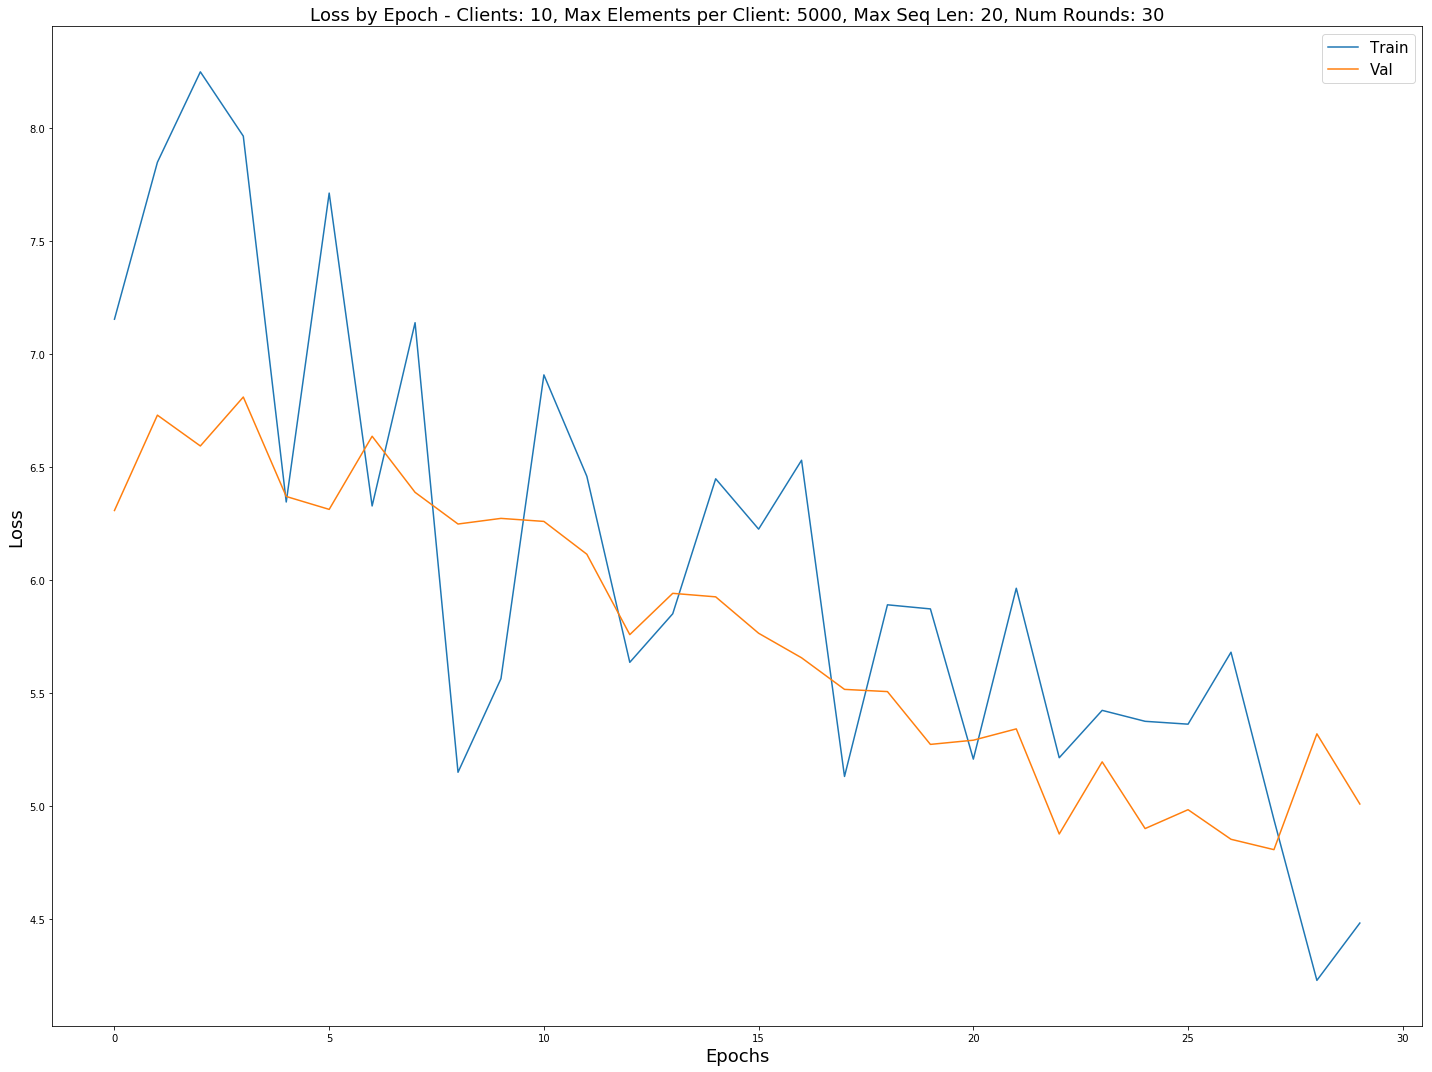

In [20]:
fig, ax = plt.subplots(figsize=(20, 15))
x_axis = range(0, NUM_ROUNDS)
ax.plot(x_axis, train_metrics_tracker.get_metrics_by_name('loss'), label='Train')
ax.plot(x_axis, val_metrics_tracker.get_metrics_by_name('loss'), label='Val')
ax.legend(loc='best', prop={'size': 15})
plt.title('Loss by Epoch - {}'.format(round_config), fontsize=18)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.tight_layout()
plt.savefig(SAV + 'Loss by Epoch.png')
plt.show()

### Plot Train and Validation Accuracy

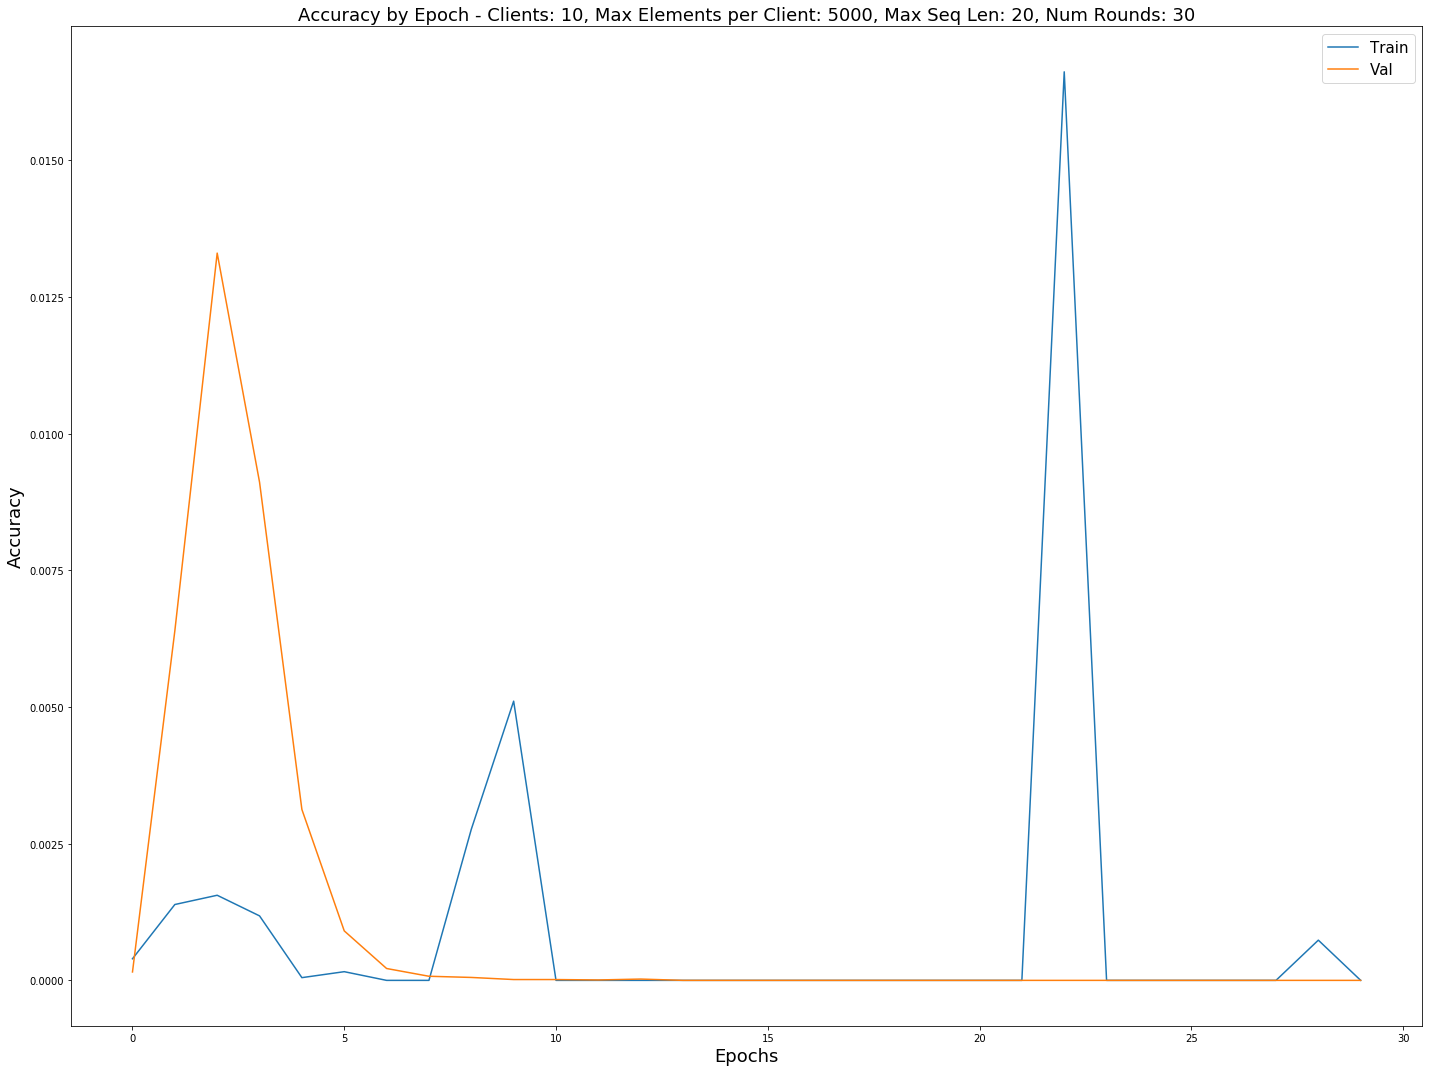

In [21]:
fig, ax = plt.subplots(figsize=(20, 15))
x_axis = range(0, NUM_ROUNDS)
ax.plot(x_axis, train_metrics_tracker.get_metrics_by_name('accuracy'), label='Train')
ax.plot(x_axis, val_metrics_tracker.get_metrics_by_name('accuracy'), label='Val')
ax.legend(loc='best', prop={'size': 15})
plt.title('Accuracy by Epoch - {}'.format(round_config), fontsize=18)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.tight_layout()
plt.savefig(SAV + 'Accuracy by Epoch.png')
plt.show()

### Load Train Sample Stats

In [22]:
examples = np.load(SAV + 'num_examples.npy')
tokens = np.load(SAV + 'num_tokens.npy')
tokens_no_oov = np.load(SAV + 'num_tokens_no_oov.npy')

### Compute Train Sample Means and Standard Deviations

In [23]:
train_sample_stats = ['Examples', 'Tokens', 'Tokens No OOV']
means = [np.mean(examples), np.mean(tokens), np.mean(tokens_no_oov)]
stdvs = [np.std(examples), np.std(tokens), np.std(tokens_no_oov)]

### Plot Train Sample Stats

<Figure size 432x288 with 0 Axes>

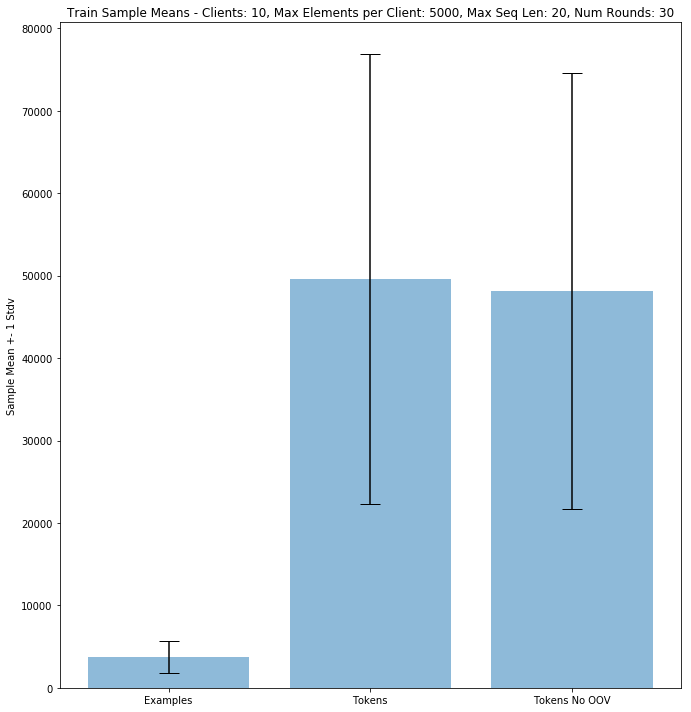

In [24]:
plt.clf()
fig, ax = plt.subplots(figsize=(10, 10))
x_pos = np.arange(len(train_sample_stats))
ax.bar(x_pos, means, yerr=stdvs, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Sample Mean +- 1 Stdv')
ax.set_xticks(x_pos)
ax.set_xticklabels(train_sample_stats)
ax.set_title('Train Sample Means - {}'.format(round_config))
plt.tight_layout()
plt.savefig(SAV + '{} Round Train Sample Means.png'.format(NUM_ROUNDS))
plt.show()

<Figure size 432x288 with 0 Axes>

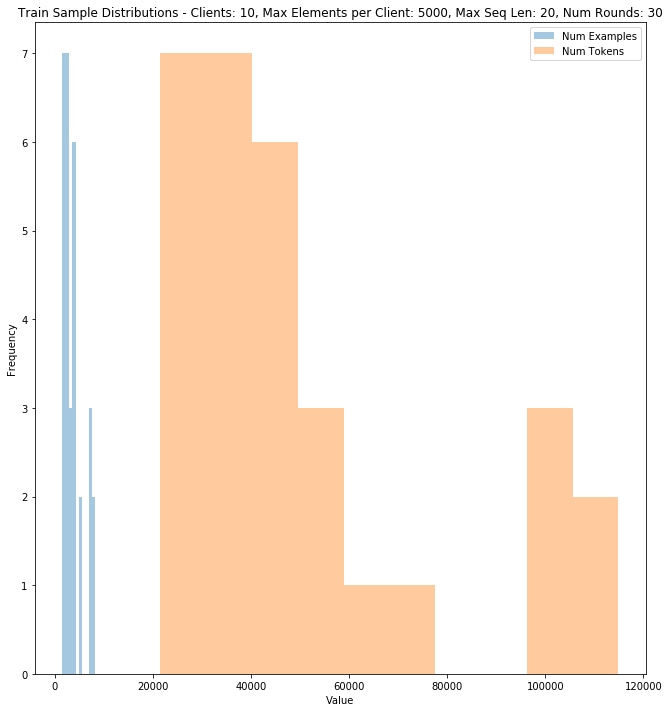

In [25]:
plt.clf()
fig, ax = plt.subplots(figsize=(10, 10))
plt.hist(examples, alpha=0.4, label='Num Examples')
plt.hist(tokens, alpha=0.4, label='Num Tokens')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Train Sample Distributions - {}'.format(round_config))
plt.legend(loc='best')
plt.tight_layout()
plt.savefig(SAV + '{} Round Train Sample Distributions.png'.format(NUM_ROUNDS))
plt.show()

<Figure size 432x288 with 0 Axes>

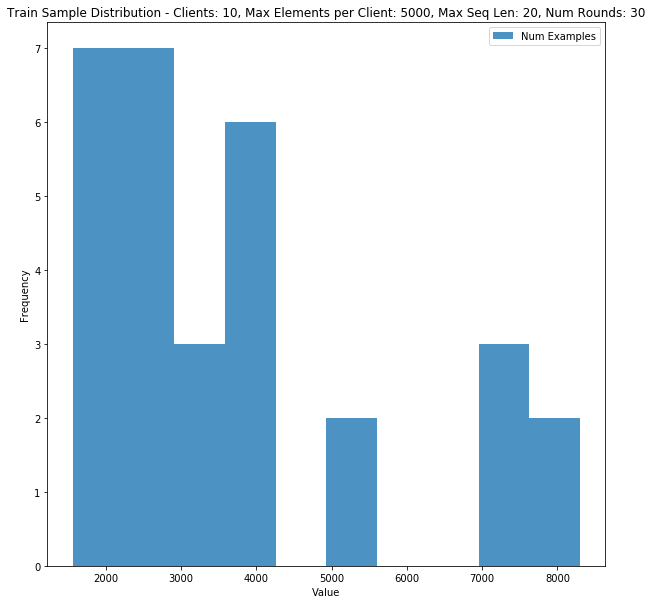

In [26]:
plt.clf()
fig, ax = plt.subplots(figsize=(10, 10))
plt.hist(examples, alpha=0.8, label='Num Examples')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Train Sample Distribution - {}'.format(round_config))
plt.legend(loc='best')
plt.show()

<Figure size 432x288 with 0 Axes>

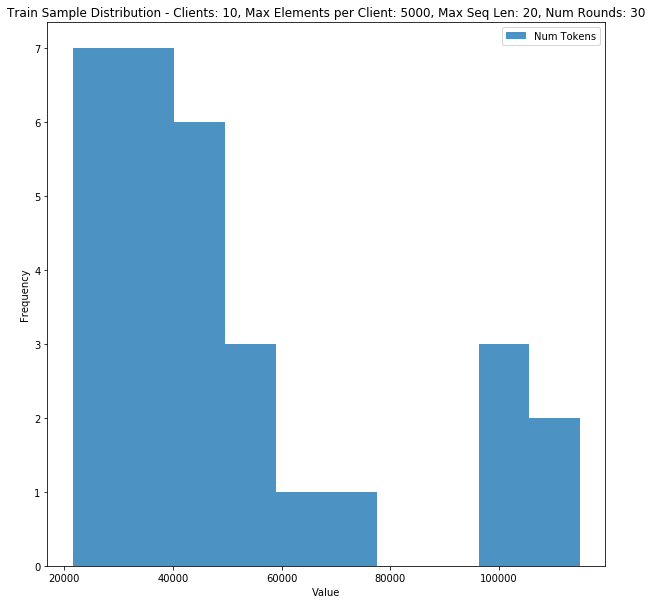

In [27]:
plt.clf()
fig, ax = plt.subplots(figsize=(10, 10))
plt.hist(tokens, alpha=0.8, label='Num Tokens')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Train Sample Distribution - {}'.format(round_config))
plt.legend(loc='best')
plt.show()

<Figure size 432x288 with 0 Axes>

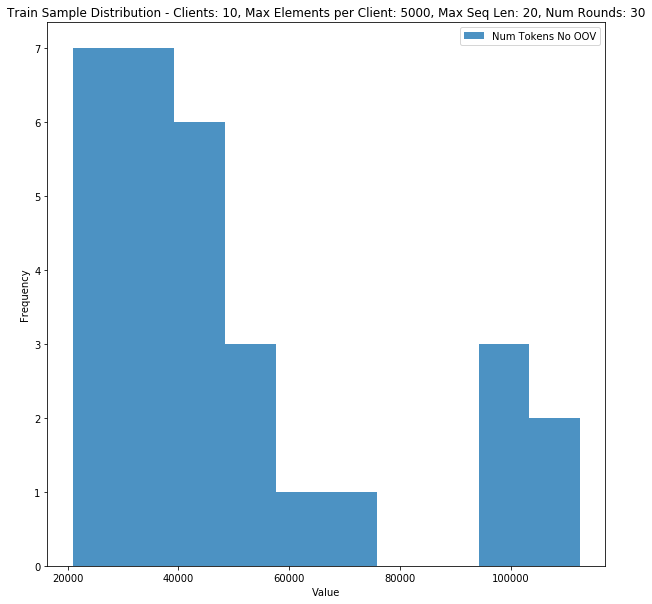

In [28]:
plt.clf()
fig, ax = plt.subplots(figsize=(10, 10))
plt.hist(tokens_no_oov, alpha=0.8, label='Num Tokens No OOV')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Train Sample Distribution - {}'.format(round_config))
plt.legend(loc='best')
plt.show()